# Gr64f Reinforcement based RL Modelling

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

from flyjax.experiment.get import fetch_behavioral_data, get_experiments
from flyjax.utils.plotting import plot_single_experiment_data


import seaborn as sns
sns.set(style='ticks')
sns.set_palette('colorblind')
plt.rcParams['font.sans-serif'] = 'Arial'

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

data_folder = '../../../data/gr64f_dmVS_14-09-2023/' # folder containing the data
processed_folder = 'processed_data' # folder containing the processed data
minimal_trials = 180 # minimal number of trials to consider a fly to be included in the analysis

choices, rewards, metadata = fetch_behavioral_data(data_folder, minimal_trials, remove_control=True)

n_experiments = len(metadata)

# set the seed for reproducibility
np.random.seed(0)

## Testing a literature inspired Model for Reinforcement Learning
Based on Differential Forgetting Q-Learning (DFQ) by Ito and Doya (2009).

In [9]:
from flyjax.fitting.cv import parallel_k_fold_cross_validation_train
from flyjax.fitting.samplers import base_randn_sampler
from flyjax.agent.rl.zoo import differential_forgetting_q_agent, differential_q_agent, forgetting_q_agent, q_agent
from flyjax.agent.base import random_policy
from functools import partial

In [10]:
experiments = [(choices[i], rewards[i]) for i in range(n_experiments)]

### Fitting the DFQ Model to the Gr64f Data

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=4)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=differential_forgetting_q_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

## Ablation Study
We will test the DFQ model on the Gr64f data and compare it:
1. Differential Q-Learning (DQ) model : by ablation of the forgetting term
2. Forgetting Q-Learning (FQ) model : by ablation of the differential reward term
3. Q-Learning (Q) model : by ablation of both the forgetting and differential reward terms

### Fit the DQ Model to the Gr64f Data

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=3)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=differential_q_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dq_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

### Fit the FQ Model to the Gr64f Data

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=3)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=forgetting_q_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'fq_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=2)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=q_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'q_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

### Evaluate the random policy model on the Gr64f Data

In [ ]:
from flyjax.fitting.evaluation import negative_log_likelihood_experiment

total_pred_ll = 0.0
per_experiment_ll = {}
for exp_idx, (choices, rewards) in enumerate(experiments):
    # Compute predicted log likelihood: negative NLL.
    ll = -float(
        negative_log_likelihood_experiment(None, random_policy, choices, rewards)
    )
    per_experiment_ll[exp_idx] = ll
    total_pred_ll += ll
print(f"predictive log-likelihood: {total_pred_ll:.2f}")

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': None
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'random_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

## Load and compare the Gr64f data with the DFQ model + ablations

In [13]:
# load the results
dfq_results_file = os.path.join(processed_folder, 'dfq_results.pkl')
dq_results_file = os.path.join(processed_folder, 'dq_results.pkl')
fq_results_file = os.path.join(processed_folder, 'fq_results.pkl')
q_results_file = os.path.join(processed_folder, 'q_results.pkl')
random_results_file = os.path.join(processed_folder, 'random_results.pkl')

with open(dfq_results_file, 'rb') as f:
    dfq_results = pickle.load(f)
with open(dq_results_file, 'rb') as f:
    dq_results = pickle.load(f)
with open(fq_results_file, 'rb') as f:
    fq_results = pickle.load(f)
with open(q_results_file, 'rb') as f:
    q_results = pickle.load(f)
with open(random_results_file, 'rb') as f:
    random_results = pickle.load(f)

These are nested models, so we can compare them using a likelihood ratio test. We will additionally compare the models using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) and also percentage of variance explained by the models.

In [14]:
# since the model to evaluate is DFQ, we will first use the log likelihood ratio test to compare it to the other models
from flyjax.fitting.model_comparison import likelihood_ratio_test, aic, bic

# compute the log likelihood ratio test of DFQ every other model
dfq_vs_dq = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=dq_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=3
            )
dfq_vs_fq = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=fq_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=3
            )
dfq_vs_q = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=q_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=2
            )
dfq_vs_random = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=random_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=0
            )
print(f"DFQ vs DQ: {dfq_vs_dq:.2f}; DFQ vs FQ: {dfq_vs_fq:.2f}; DFQ vs Q: {dfq_vs_q:.2f}; DFQ vs Random: {dfq_vs_random:.2f}")

DFQ vs DQ: 0.00; DFQ vs FQ: 0.00; DFQ vs Q: 0.00; DFQ vs Random: 0.00


The fact that the likelihood ratio test is significant for the nested models suggests that every term in the DFQ model is important for explaining the data. Lets plot the results and compare the models.

DFQ vs No Forgetting: p-val:1.91e-46,***
DFQ vs No Choice Bias: p-val:6.10e-03,**
DFQ vs No Forgetting
or Choice Bias: p-val:5.98e-56,***
DFQ vs No Learning: p-val:3.08e-53,***


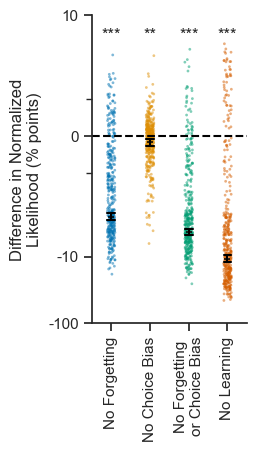

In [15]:
# create a subject-level dataframe
dfq_subjects = pd.DataFrame(dfq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_subjects['model'] = 'DFQ'
dq_subjects = pd.DataFrame(dq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dq_subjects['model'] = 'DQ'
fq_subjects = pd.DataFrame(fq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
fq_subjects['model'] = 'FQ'
q_subjects = pd.DataFrame(q_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
q_subjects['model'] = 'Q'
random_subjects = pd.DataFrame(random_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
random_subjects['model'] = 'Random'
# concatenate the dataframes
subjects = pd.concat([dfq_subjects, dq_subjects, fq_subjects, q_subjects, random_subjects])

# sort by model and subject
subjects = subjects.sort_values(by=['model', 'subject']).reset_index(drop=True)

# for each subject, get the number of trials
subjects['n_trials'] = subjects['subject'].apply(lambda x: len(experiments[x][0]))
# get normalized likelihoods exp(log likelihood/n_trials)
subjects['normalized_likelihood'] = np.exp(subjects['log_likelihood']/subjects['n_trials'])

# from each subject, divide the log likelihood of the DFQ model
subjects['normalized_likelihood_change'] = subjects.groupby('subject')['normalized_likelihood'].transform(lambda x: x/x.iloc[0])
# convert the log likelihoods to a percentage scale
subjects['normalized_likelihood_change'] = (subjects['normalized_likelihood_change']-1)*100


# plot the log likelihoods of the different models with paired scatter plots
plt.figure(figsize=(2, 4))
# drop DFQ vs DFQ
subjects_change = subjects[subjects['model'] != 'DFQ']
# change the names of the models
subjects_change.loc[:, 'model'] = subjects_change['model'].replace({
    'DQ': 'No Forgetting',
    'FQ': 'No Choice Bias',
    'Q': 'No Forgetting\nor Choice Bias',
    'Random': 'No Learning'
})
sns.stripplot(x='model', y='normalized_likelihood_change', data=subjects_change, jitter=True, alpha=0.5, palette='colorblind', hue='model', size=2, zorder=0)
sns.pointplot(x='model', y='normalized_likelihood_change', data=subjects_change, markers='_', errorbar=('ci', 95), capsize=0.2, color='black', zorder=1, linewidth=1.5, linestyles='none')
plt.ylabel('Difference in Normalized\nLikelihood (% points)')
plt.axhline(0, color='black', linestyle='--')
sns.despine()
plt.yscale('symlog')
plt.ylim(-100, 10)
plt.yticks([-100, -10, 0, 10], ['-100', '-10', '0', '10'])
plt.xticks(rotation=90)
plt.xlabel('')

# add the significance stars for the paired Wilcoxon signed-rank test between DFQ and the other models
for model in subjects_change['model'].unique():
    if model == 'DFQ':
        continue
    # perform the Wilcoxon signed-rank test
    dfq_model = subjects[subjects['model'] == 'DFQ']['normalized_likelihood']
    other_model = subjects_change[subjects_change['model'] == model]['normalized_likelihood']
    _, p = stats.wilcoxon(dfq_model, other_model)
    # adjust for multiple comparisons (Bonferroni correction)
    p *= len(subjects_change['model'].unique())
    # add the significance stars
    plt.text(subjects_change['model'].unique().tolist().index(model), 5, significance_stars(p), ha='center', va='center')
    print(f"DFQ vs {model}: p-val:{p:.2e},{significance_stars(p)}")

plt.show()


## Additive Model Comparison to see if other features are important

We will also see if other features are important by comparing the DFQ model to more advanced models by adding more features to the model such as:
1) Learnt initial Q values
2) Epsilon softmax mixed policy
3) Different learning rates for positive and negative reward prediction errors

In [16]:
from flyjax.agent.rl.zoo import dfq_agent_with_dual_lr, dfq_agent_with_epsilon_softmax, dfq_agent_with_init, dfq_agent_with_dynamic_exploration, advanced_rl_agent

In [17]:
init_param_sampler = partial(base_randn_sampler, n_params=6)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_init,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_init_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)


--- Restart 1/10 ---

--- Restart 1/10 ---

--- Restart 1/10 ---

--- Restart 1/10 ---

--- Restart 1/10 ---


KeyboardInterrupt: 

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=5)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_epsilon_softmax,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_epsilon_softmax_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=5)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_dual_lr,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_dual_lr_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=7)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_dynamic_exploration,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)


--- Restart 1/10 ---

--- Restart 1/10 ---

--- Restart 1/10 ---

--- Restart 1/10 ---

--- Restart 1/10 ---


In [ ]:
# load the results
dfq_init_results_file = os.path.join(processed_folder, 'dfq_init_results.pkl')
dfq_epsilon_softmax_results_file = os.path.join(processed_folder, 'dfq_epsilon_softmax_results.pkl')
dfq_dual_lr_results_file = os.path.join(processed_folder, 'dfq_dual_lr_results.pkl')
dfq_dynamic_exploration_results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')

with open(dfq_init_results_file, 'rb') as f:
    dfq_init_results = pickle.load(f)
with open(dfq_epsilon_softmax_results_file, 'rb') as f:
    dfq_epsilon_softmax_results = pickle.load(f)
with open(dfq_dual_lr_results_file, 'rb') as f:
    dfq_dual_lr_results = pickle.load(f)
with open(dfq_dynamic_exploration_results_file, 'rb') as f:
    dfq_dynamic_exploration_results = pickle.load(f)

These are still nested models, so we can compare them using a likelihood ratio test comparing the DFQ model to the more advanced models. We will additionally compare the models using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

In [ ]:
# perform the log likelihood ratio test between the different models
from flyjax.fitting.model_comparison import likelihood_ratio_test, aic, bic

dfq_vs_init = likelihood_ratio_test(
            ll_full=dfq_init_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=6,
            num_params_restricted=4
            )
dfq_vs_epsilon_softmax = likelihood_ratio_test(
            ll_full=dfq_epsilon_softmax_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=5,
            num_params_restricted=4
            )
dfq_vs_dual_lr = likelihood_ratio_test(
            ll_full=dfq_dual_lr_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=5,
            num_params_restricted=4
            )  
dfq_vs_dynamic_exploration = likelihood_ratio_test(
            ll_full=dfq_dynamic_exploration_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=7,
            num_params_restricted=4
            )
print(f"DFQ vs Init: {dfq_vs_init:.2f}; DFQ vs Epsilon Softmax: {dfq_vs_epsilon_softmax:.2f}; DFQ vs Dual LR: {dfq_vs_dual_lr:.2f}; DFQ vs Dynamic Exploration: {dfq_vs_dynamic_exploration:.2f}")

In [ ]:
# create a subject-level dataframe
dfq_subjects = pd.DataFrame(dfq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_subjects['model'] = 'DFQ'
dfq_init_subjects = pd.DataFrame(dfq_init_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_init_subjects['model'] = 'DFQ with Init'
dfq_epsilon_softmax_subjects = pd.DataFrame(dfq_epsilon_softmax_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_epsilon_softmax_subjects['model'] = 'DFQ with Epsilon Softmax'
dfq_dual_lr_subjects = pd.DataFrame(dfq_dual_lr_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_dual_lr_subjects['model'] = 'DFQ with Dual LR'
dfq_adv_subjects = pd.DataFrame(dfq_dynamic_exploration_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_adv_subjects['model'] = 'DFQ with Dynamic Exploration'
# concatenate the dataframes
subjects = pd.concat([dfq_subjects, dfq_init_subjects, dfq_epsilon_softmax_subjects, dfq_dual_lr_subjects, dfq_adv_subjects])

# sort by model and subject
subjects = subjects.sort_values(by=['model', 'subject']).reset_index(drop=True)

# get index for DFQ model
dfq_idx = subjects[subjects['subject']==0].reset_index(drop=True)
dfq_idx = dfq_idx[dfq_idx['model']=='DFQ'].index[0]
print(dfq_idx)

# for each subject, get the number of trials
subjects['n_trials'] = subjects['subject'].apply(lambda x: len(experiments[x][0]))
# get normalized likelihoods exp(log likelihood/n_trials)
subjects['normalized_likelihood'] = np.exp(subjects['log_likelihood']/subjects['n_trials'])

# from each subject, divide the log likelihood of the DFQ model
subjects['normalized_likelihood_change'] = subjects.groupby('subject')['normalized_likelihood'].transform(lambda x: x/x.iloc[dfq_idx])
# convert the log likelihoods to a percentage scale
subjects['normalized_likelihood_change'] = (subjects['normalized_likelihood_change']-1)*100

# plot the change in log likelihoods of the different models with paired scatter plots
plt.figure(figsize=(2, 4))
# drop DFQ vs DFQ
subjects_change = subjects[subjects['model'] != 'DFQ']
# change the names of the models
subjects_change.loc[:, 'model'] = subjects_change['model'].replace({
    'DFQ with Init': '+ Value Initialization',
    'DFQ with Epsilon Softmax': '+ Epsilon Softmax Exploration',
    'DFQ with Dual LR': '+ Dual Learning Rates',
    'DFQ with Dynamic Exploration': '+ Dynamic Exploration'
})

sns.stripplot(x='model', y='normalized_likelihood_change', data=subjects_change, jitter=True, alpha=0.5, palette='colorblind', hue='model', size=2, zorder=0)
sns.pointplot(x='model', y='normalized_likelihood_change', data=subjects_change, markers='_', errorbar=('ci', 95), capsize=0.2, color='black', zorder=1, linewidth=1.5, linestyles='none')
plt.ylabel('Difference in Normalized\nLikelihood (% points)')
plt.axhline(0, color='black', linestyle='--')
sns.despine()

plt.xticks(rotation=90)
plt.xlabel('')
# add the significance stars for the paired Wilcoxon signed-rank test between DFQ and the other models
for model in subjects_change['model'].unique():
    if model == 'DFQ':
        continue
    # perform the Wilcoxon signed-rank test
    dfq_model = subjects[subjects['model'] == 'DFQ'].sort_values(by='subject')['normalized_likelihood'].values
    other_model = subjects_change[subjects_change['model'] == model].sort_values(by='subject')['normalized_likelihood'].values
    _, p = stats.wilcoxon(dfq_model, other_model)
    # adjust for multiple comparisons (Bonferroni correction)
    p *= len(subjects_change['model'].unique())
    # add the significance stars
    plt.text(subjects_change['model'].unique().tolist().index(model), 2, significance_stars(p), ha='center', va='center')
    print(f"DFQ vs {model}: p-val:{p:.2e},{significance_stars(p)}")
plt.show()



In [ ]:
set1 = subjects[subjects['model'] == 'DFQ with Init'].sort_values(by='subject')['normalized_likelihood'].values
set2 = subjects[subjects['model'] == 'DFQ'].sort_values(by='subject')['normalized_likelihood'].values
plt.scatter(set1, set2)
plt.plot([np.min(set1), np.max(set1)], [np.min(set1), np.max(set1)], color='black', linestyle='--')
plt.xlabel('DFQ with Dual LR')
plt.ylabel('DFQ')
plt.show()
s,p = stats.wilcoxon(set1, set2)
p*=4
p
